# ШАГ 1

# Создание таблицы customer

In [ ]:
# Создание таблицы customer

CREATE TABLE customer (
    customer_id INTEGER PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    gender VARCHAR(10),
    dob DATE,
    job_title VARCHAR(100),
    job_industry_category VARCHAR(100),
    wealth_segment VARCHAR(50),
    deceased_indicator VARCHAR(10),
    owns_car VARCHAR(10),
    address VARCHAR(255),
    postcode VARCHAR(10),
    state VARCHAR(100),
    country VARCHAR(100),
    property_valuation INTEGER
);

# Создание таблицы product

In [ ]:
CREATE TABLE product (
    product_id INTEGER PRIMARY KEY,
    brand VARCHAR(100),
    product_line VARCHAR(50),
    product_class VARCHAR(50),
    product_size VARCHAR(50),
    list_price DECIMAL(10,2),
    standard_cost DECIMAL(10,2)
);

# Создание таблицы orders

In [ ]:
CREATE TABLE orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER NOT NULL,
    order_date DATE NOT NULL,
    online_order VARCHAR(10),
    order_status VARCHAR(20),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);

# Создание таблицы order_items

In [ ]:
CREATE TABLE order_items (
    order_item_id INTEGER PRIMARY KEY,
    order_id INTEGER NOT NULL,
    product_id INTEGER NOT NULL,
    quantity INTEGER NOT NULL,
    item_list_price_at_sale DECIMAL(10,2),
    item_standard_cost_at_sale DECIMAL(10,2),
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES product(product_id)
);

# Загружаем данные из файла используя корректный разделитель

In [ ]:
Copy customer FROM '/tmp/customer.csv' WITH (FORMAT CSV, HEADER true, DELIMITER ';');

# Убираем дубликаты из таблицы product

In [ ]:
# Создаем временную таблицу temp_product
CREATE TEMP TABLE temp_product AS SELECT * FROM product WHERE 1=0;

# Импортируем данные во временную таблицу
Copy temp_product FROM '/tmp/product.csv' WITH (FORMAT CSV, HEADER true, DELIMITER ',');

# Вставляем только уникальные записи, пропуская дубликаты
INSERT INTO product 
SELECT DISTINCT ON (product_id) * 
FROM temp_product 
ORDER BY product_id
ON CONFLICT (product_id) DO NOTHING;

# Удаляем временную таблицу
DROP TABLE temp_product;

# Загружаем данные игнорируя несуществующие ссылки(customer_id)

In [2]:
#Отключаем проверку внешних ключей
SET session_replication_role = 'replica';

Copy orders FROM '/tmp/orders.csv' WITH (FORMAT CSV, HEADER true, DELIMITER ','); 

#Включаем проверку внешних ключей
SET session_replication_role = 'origin';

#Удаляем записи с несуществующими ссылками
DELETE FROM orders 
WHERE customer_id NOT IN (SELECT customer_id FROM customer); 

SyntaxError: invalid syntax (3356751739.py, line 2)

# Загружаем данные в корректном формате и существующими ссылками

In [ ]:
#  Создать временную таблицу с DECIMAL для quantity
CREATE TEMP TABLE temp_order_items (
    order_item_id INTEGER,
    order_id INTEGER,
    product_id INTEGER,
    quantity DECIMAL(10,1),
    item_list_price_at_sale DECIMAL(10,2),
    item_standard_cost_at_sale DECIMAL(10,2)
);
#  Импортировать во временную таблицу

Copy temp_order_items FROM '/tmp/order_items.csv' WITH (FORMAT CSV, HEADER true, DELIMITER ','); 

#  Вставить данные в основную таблицу (округлив quantity)

INSERT INTO order_items 
SELECT 
    order_item_id,
    temp_order_items.order_id,
    product_id,
    ROUND(quantity) as quantity,  # округляем до целого
    item_list_price_at_sale,
    item_standard_cost_at_sale
FROM temp_order_items
INNER JOIN orders ON temp_order_items.order_id = orders.order_id;

#  Удалить временную таблицу

DROP TABLE temp_order_items;

# ШАГ 2

## 1. Вывести все уникальные бренды, у которых есть хотя бы один продукт со стандартной стоимостью выше 1500 долларов, и суммарными продажами не менее 1000 единиц.

In [3]:
SELECT DISTINCT p.brand
FROM product p
JOIN order_items o ON o.product_id = p.product_id
WHERE o.item_standard_cost_at_sale > 1500
	AND p.product_id IN (
		SELECT product_id 
		FROM order_items
		GROUP BY product_id
		HAVING SUM(quantity) >= 1000
);

SyntaxError: invalid syntax (3854692211.py, line 1)

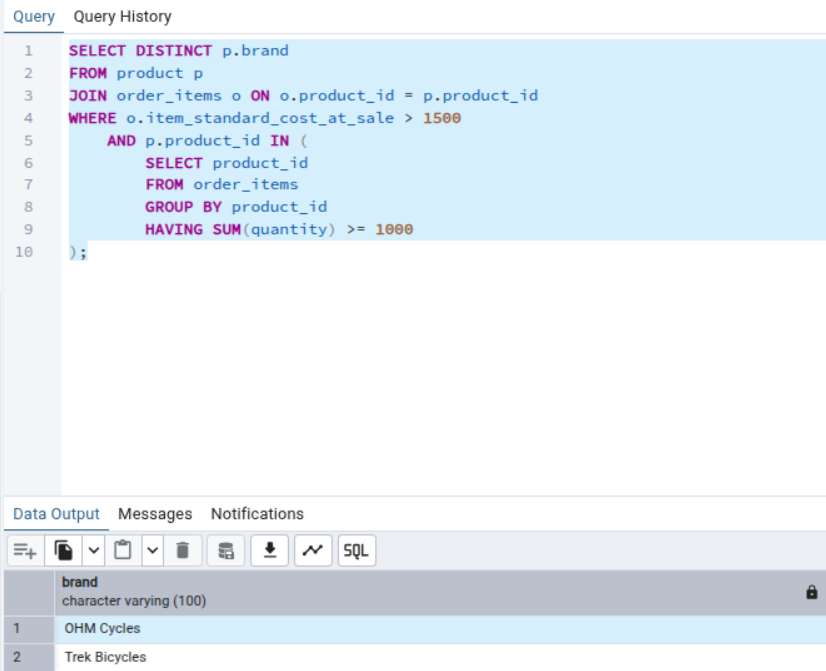

## 2. Для каждого дня в диапазоне с 2017-04-01 по 2017-04-09 включительно вывести количество подтвержденных онлайн-заказов и количество уникальных клиентов, совершивших эти заказы.

In [ ]:
SELECT  order_date, COUNT(customer_id), COUNT(order_id)
FROM orders
WHERE order_date BETWEEN '2017-04-01' AND '2017-04-09'
	AND online_order = 'True' 
	AND order_status = 'Approved'
GROUP BY order_date
ORDER BY order_date;


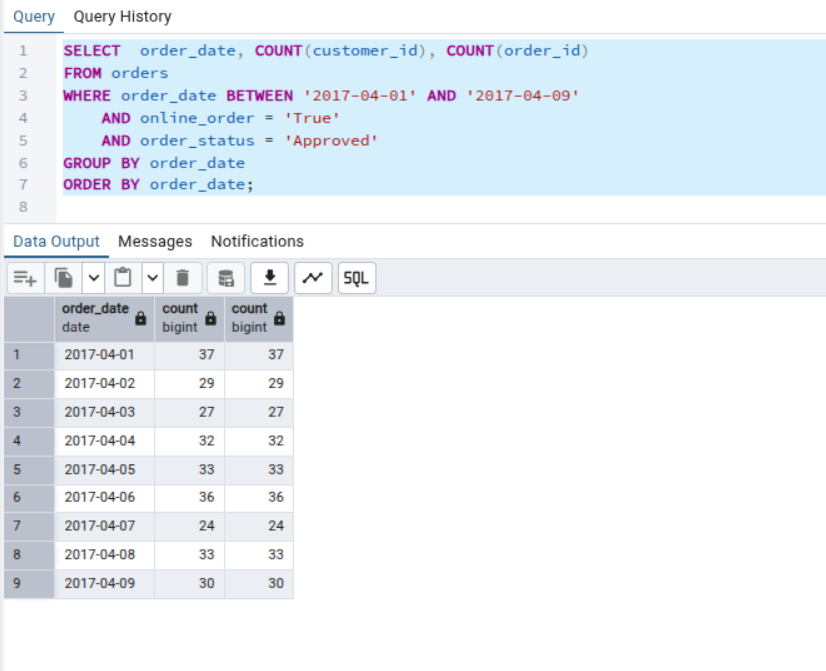

## 3. Вывести профессии клиентов:
## - из сферы IT, чья профессия начинается с Senior;
## - из сферы Financial Services, чья профессия начинается с Lead.
## - Для обеих групп учитывать только клиентов старше 35 лет. Объединить выборки с помощью UNION ALL.

In [ ]:
SELECT job_title
FROM customer
WHERE job_industry_category = 'IT'
    AND job_title LIKE 'Senior%'
    AND EXTRACT(YEAR FROM AGE(CURRENT_DATE, dob)) > 35
	
UNION ALL

SELECT job_title
FROM customer
WHERE job_industry_category = 'Financial Services'
    AND job_title LIKE 'Lead%'
    AND EXTRACT(YEAR FROM AGE(CURRENT_DATE, dob)) > 20
ORDER BY job_title;

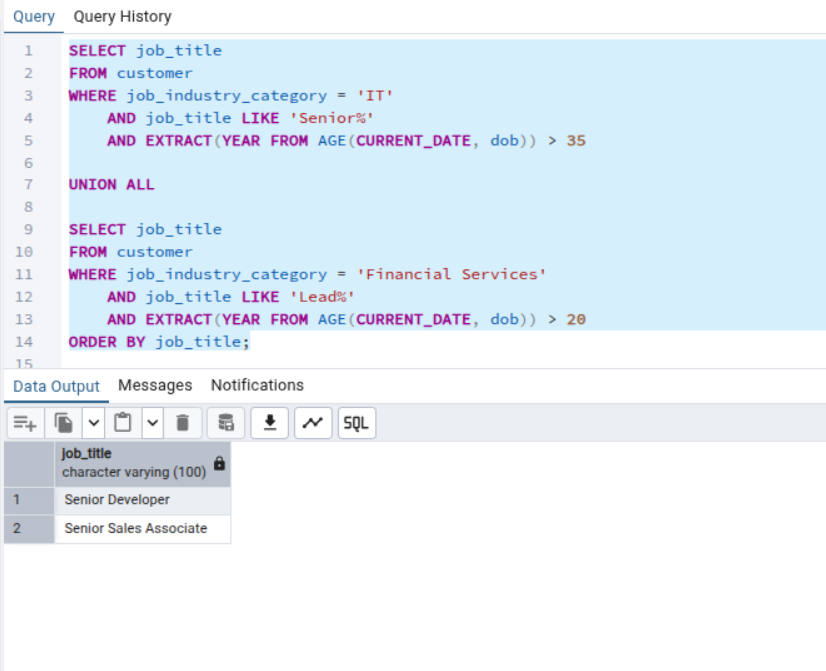

## 4. Вывести бренды, которые были куплены клиентами из сферы Financial Services, но не были куплены клиентами из сферы IT.

In [ ]:
SELECT DISTINCT p.brand
FROM product p
WHERE p.product_id IN (
    SELECT oi.product_id
    FROM order_items oi
    JOIN orders o ON oi.order_id = o.order_id
    JOIN customer c ON o.customer_id = c.customer_id
    WHERE c.job_industry_category = 'Financial Services'
)
AND p.product_id NOT IN (
    SELECT oi.product_id
    FROM order_items oi
    JOIN orders o ON oi.order_id = o.order_id
    JOIN customer c ON o.customer_id = c.customer_id
    WHERE c.job_industry_category = 'IT'
);

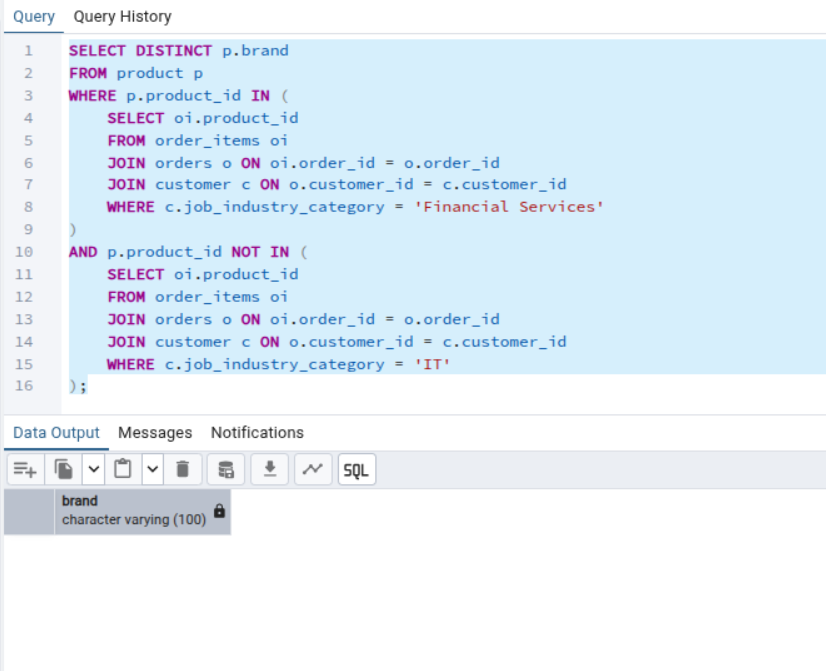

## 5. Вывести 10 клиентов (ID, имя, фамилия), которые совершили наибольшее количество онлайн-заказов (в штуках) брендов Giant Bicycles, Norco Bicycles, Trek Bicycles, при условии, что они активны и имеют оценку имущества (property_valuation) выше среднего среди клиентов из того же штата.

In [ ]:
SELECT 
    c.customer_id,
    c.first_name,
    c.last_name,
    COUNT(DISTINCT o.order_id) AS online_orders_count
FROM customer c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN product p ON oi.product_id = p.product_id
JOIN(
    SELECT 
        state,
        AVG(property_valuation) AS avg_val
    FROM customer
    WHERE deceased_indicator = 'N'
    GROUP BY state
) sa ON c.state = sa.state
WHERE c.deceased_indicator = 'N'
    AND o.online_order = 'True'
    AND p.brand IN ('Giant Bicycles', 'Norco Bicycles', 'Trek Bicycles')
    AND c.property_valuation > sa.avg_val
GROUP BY c.customer_id, c.first_name, c.last_name
ORDER BY online_orders_count DESC
LIMIT 10;

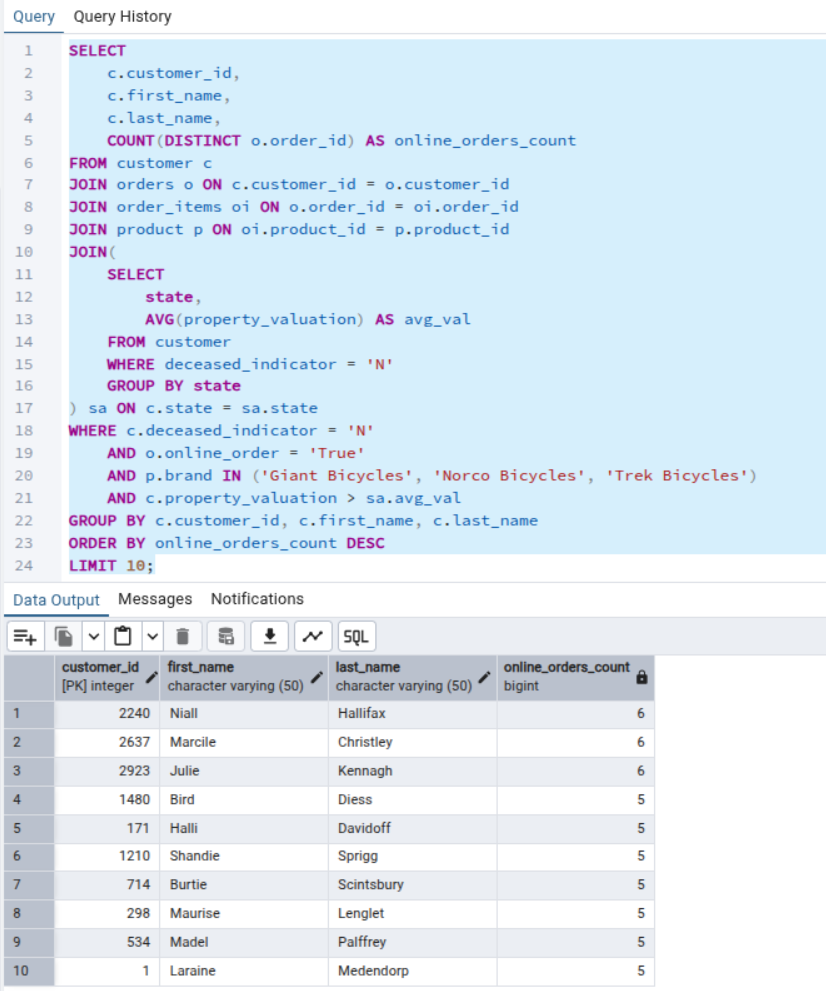

## 6. Вывести всех клиентов (ID, имя, фамилия), у которых нет подтвержденных онлайн-заказов за последний год, но при этом они владеют автомобилем и их сегмент благосостояния не Mass Customer.

In [ ]:
SELECT 
    c.customer_id,
    c.first_name,
    c.last_name
FROM customer c
LEFT JOIN orders o ON c.customer_id = o.customer_id
    AND o.online_order = 'True'
    AND o.order_status = 'Approved'
    AND o.order_date >= CURRENT_DATE - INTERVAL '1 year'
WHERE c.owns_car = 'Yes'
    AND c.wealth_segment != 'Mass Customer'
    AND o.order_id IS NULL
ORDER BY c.customer_id;

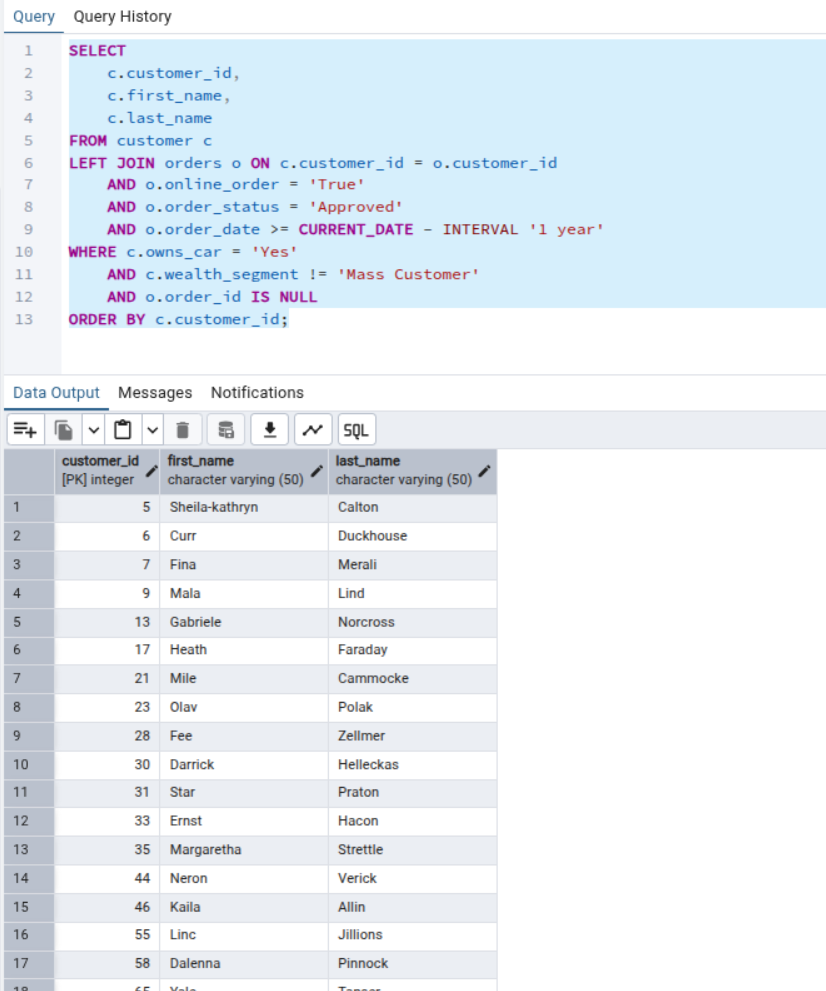

## 7. Вывести всех клиентов из сферы 'IT' (ID, имя, фамилия), которые купили 2 из 5 продуктов с самой высокой list_price в продуктовой линейке Road.

In [ ]:
SELECT 
    c.customer_id,
    c.first_name,
    c.last_name
FROM customer c
WHERE c.job_industry_category = 'IT'
    AND c.customer_id IN (
        SELECT o.customer_id
        FROM orders o
        JOIN order_items oi ON o.order_id = oi.order_id
        WHERE oi.product_id IN (
            SELECT product_id
            FROM product
            WHERE product_line = 'Road'
            ORDER BY list_price DESC
            LIMIT 5
        )
        GROUP BY o.customer_id
        HAVING COUNT(DISTINCT oi.product_id) >= 2
    )
ORDER BY c.customer_id;

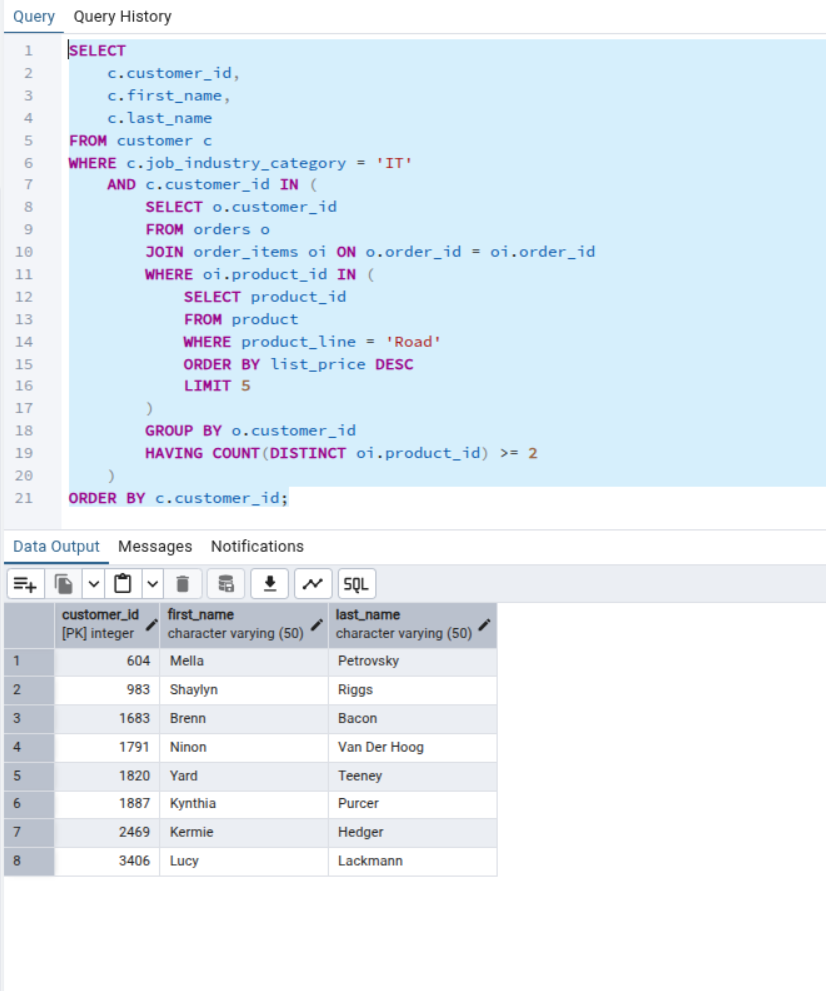

## 8. Вывести клиентов (ID, имя, фамилия, сфера деятельности) из сфер IT или Health, которые совершили не менее 3 подтвержденных заказов в период 2017-01-01 по 2017-03-01, и при этом их общий доход от этих заказов превышает 10 000 долларов.
## Разделить вывод на две группы (IT и Health) с помощью UNION.

In [ ]:
SELECT 
    c.customer_id,
    c.first_name,
    c.last_name
FROM customer c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
WHERE c.job_industry_category = 'IT'
    AND o.order_status = 'Approved'
    AND o.order_date BETWEEN '2017-01-01' AND '2017-03-01'
GROUP BY c.customer_id, c.first_name, c.last_name
HAVING COUNT(DISTINCT o.order_id) >= 3
    AND SUM(oi.quantity * oi.item_list_price_at_sale) > 10000

UNION

SELECT 
    c.customer_id,
    c.first_name,
    c.last_name
FROM customer c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
WHERE c.job_industry_category = 'Health'
    AND o.order_status = 'Approved'
    AND o.order_date BETWEEN '2017-01-01' AND '2017-03-01'
GROUP BY c.customer_id, c.first_name, c.last_name
HAVING COUNT(DISTINCT o.order_id) >= 3
    AND SUM(oi.quantity * oi.item_list_price_at_sale) > 10000

ORDER BY customer_id;

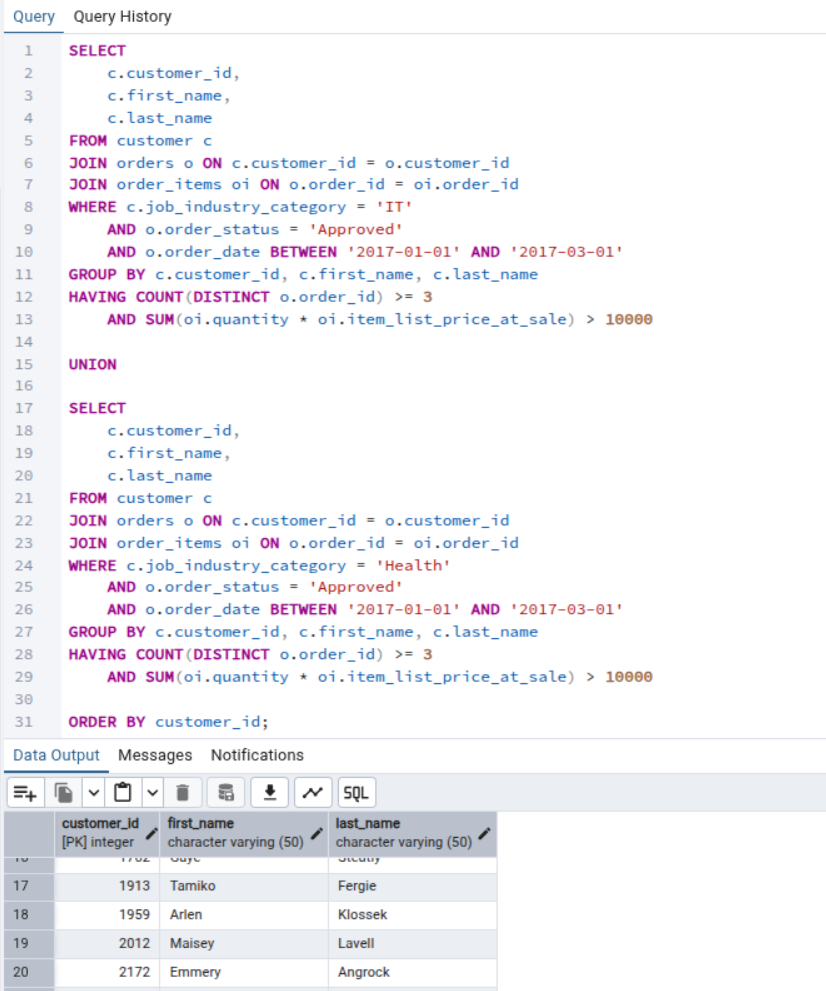